In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.utils import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense, Dropout
import matplotlib.pyplot as plt

import numpy as np
from skimage import transform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

import splitfolders

In [2]:
splitfolders.ratio(
    "https://meet.google.com/kkm-arrm-kgr-Cyst-Tumor-Stone",
   output="./dataset",
   seed=8,
   ratio=(0.75,0.12, 0.13)
)

Copying files: 12446 files [00:58, 214.40 files/s]


In [3]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory('./dataset/train',
                                                  target_size=(200, 200),
                                                  color_mode='grayscale', 
                                                  class_mode='categorical', 
                                                  batch_size=100,
                                                  )

test_dataset = test_datagen.flow_from_directory('./dataset/test',
                                                target_size=(200, 200),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size=100,
                                                shuffle=False
                                                )

valid_dataset = valid_datagen.flow_from_directory('./dataset/val',
                                                  target_size=(200, 200),
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  color_mode='grayscale',
                                                  )

Found 9332 images belonging to 4 classes.
Found 1622 images belonging to 4 classes.
Found 1492 images belonging to 4 classes.


In [4]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=train_dataset.image_shape))
model.add(MaxPool2D(2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.38))


model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.38))


model.add(Flatten())
model.add(Dense(512, activation='relu'))


model.add(Dropout(0.5))


model.add(Dense(4, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [5]:
import keras
METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
    
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=METRICS)

In [6]:
Info = model.fit(
                 train_dataset,
                 validation_data=valid_dataset,
                 epochs=5,
                 )

Epoch 1/5
94/94 [==============================] - 528s 6s/step - loss: 1.0079 - accuracy: 0.6103 - precision: 0.7296 - recall: 0.4524 - val_loss: 0.7980 - val_accuracy: 0.6830 - val_precision: 0.7568 - val_recall: 0.6300
Epoch 2/5
94/94 [==============================] - 464s 5s/step - loss: 0.7371 - accuracy: 0.7265 - precision: 0.7779 - recall: 0.6571 - val_loss: 0.5382 - val_accuracy: 0.8050 - val_precision: 0.8391 - val_recall: 0.7446
Epoch 3/5
94/94 [==============================] - 473s 5s/step - loss: 0.4579 - accuracy: 0.8323 - precision: 0.8603 - recall: 0.8033 - val_loss: 0.2888 - val_accuracy: 0.9028 - val_precision: 0.9143 - val_recall: 0.8941
Epoch 4/5
94/94 [==============================] - 490s 5s/step - loss: 0.2304 - accuracy: 0.9206 - precision: 0.9271 - recall: 0.9099 - val_loss: 0.0995 - val_accuracy: 0.9725 - val_precision: 0.9731 - val_recall: 0.9712
Epoch 5/5
94/94 [==============================] - 482s 5s/step - loss: 0.1220 - accuracy: 0.9593 - precision: 0

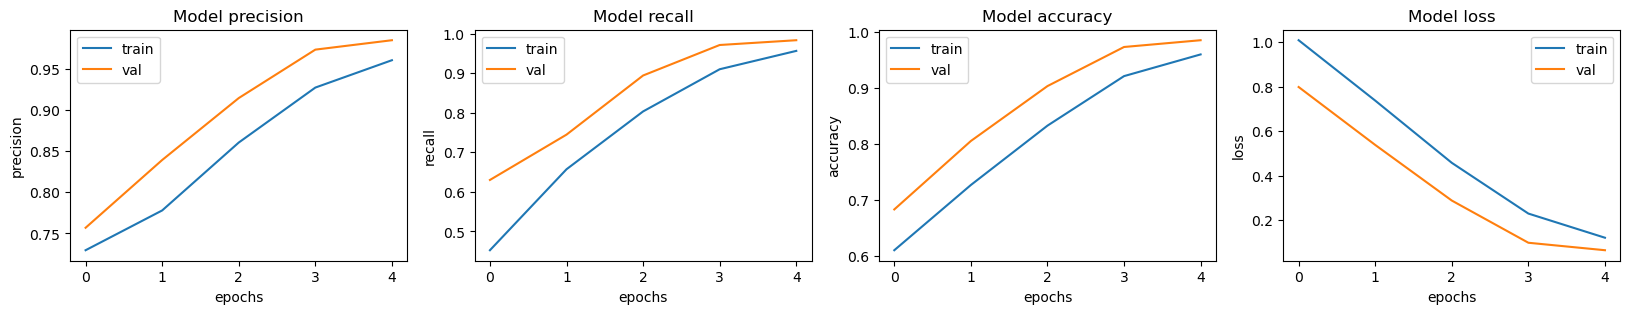

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(Info.history[met])
    ax[i].plot(Info.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [8]:
predictions = model.predict(test_dataset)

17/17 [==============================] - 53s 3s/step


In [9]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

In [10]:
def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(10,10))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlGnBu", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()

Accuracy: 0.9932182490752158
Precision: 0.9919135759434838
Recall: 0.9883042071252176
F1_score: 0.990067897307359


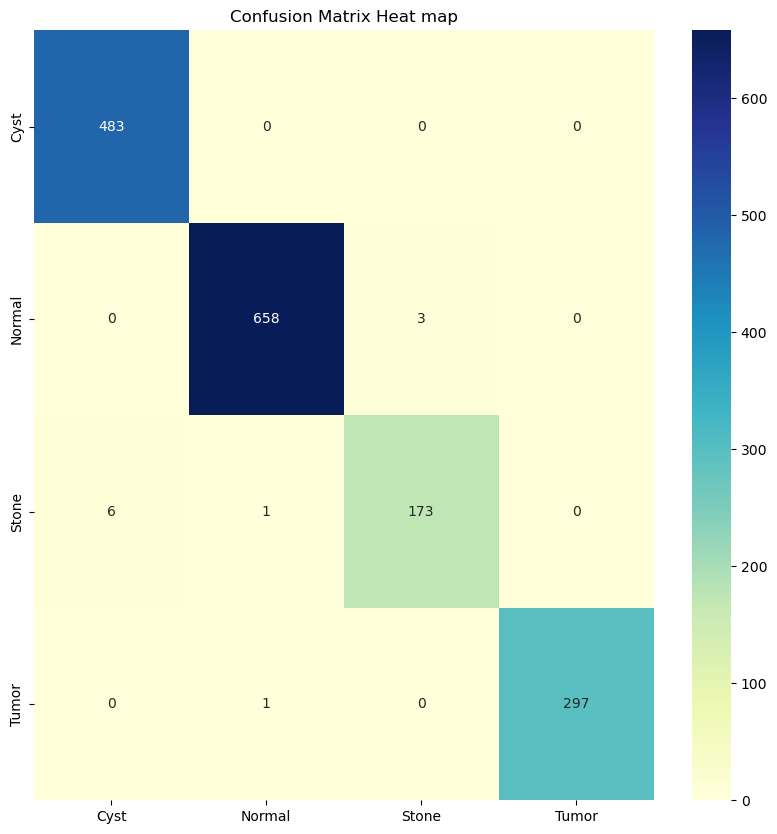

In [11]:
evaluate(test_dataset.classes,predictions)

In [12]:
model.evaluate(test_dataset)

17/17 [==============================] - 38s 2s/step - loss: 0.0424 - accuracy: 0.9932 - precision: 0.9932 - recall: 0.9932


[0.042351432144641876,
 0.9932182431221008,
 0.9932182431221008,
 0.9932182431221008]

In [13]:
model.save('model.hdf5')